In [1]:
import sys
import os
import logging

# Suppress TensorFlow / XLA logs before importing TF or src
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
logging.getLogger('tensorflow').setLevel(logging.FATAL)
try:
    from absl import logging as absl_logging
    absl_logging.set_verbosity(absl_logging.ERROR)
except ImportError:
    pass

import subprocess

REPO_URL = "https://github.com/mociatto/EcoFair.git"
REPO_DIR = "EcoFair"

if os.path.exists("./src"):
    sys.path.insert(0, os.path.abspath("."))
elif os.path.exists(os.path.join(".", REPO_DIR, "src")):
    sys.path.insert(0, os.path.abspath(REPO_DIR))
else:
    subprocess.run(["git", "clone", "--depth", "1", REPO_URL, REPO_DIR], check=True)
    sys.path.insert(0, os.path.abspath(REPO_DIR))

from src import config, utils, data_loader, models, training, features, routing, fairness, visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Cloning into 'EcoFair'...
E0000 00:00:1771776131.408552      24 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771776131.467233      24 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1771776131.913370      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771776131.913422      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771776131.913425      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771776131.913428      24 computation_placer.cc:177] computation placer already regi

In [2]:
META_TRAIN_PATH = '/kaggle/input/datasets/pasutchien/bcn20000/bcn_20k_train.csv'
META_TEST_PATH  = '/kaggle/input/datasets/pasutchien/bcn20000/bcn_20k_test.csv'
HEAVY_DIR = '/kaggle/input/notebooks/mostafaanoosha/image-feature-extractor-heavy/output/BCN20000/ResNet50'
LITE_DIR  = '/kaggle/input/notebooks/mostafaanoosha/image-feature-extractor-lite/output/BCN20000/MobileNetV3Small'

CLASSES           = ['mel', 'bcc', 'ak', 'bkl', 'nv', 'scc', 'df', 'vasc']
SAFE_CLASSES      = ['nv', 'bkl', 'df', 'vasc', 'ak']
DANGEROUS_CLASSES = ['mel', 'bcc', 'scc']

TITLE_SUFFIX = ' — BCN20000'

utils.set_seed(config.RANDOM_STATE)

In [3]:
# BCN20000 ships two separate CSV files (train / test split).
# We merge them here so the backend receives a single aligned dataset
# for cross-validation — the backend stays unaware of this detail.
meta_train = pd.read_csv(META_TRAIN_PATH)
meta_test  = pd.read_csv(META_TEST_PATH)
meta_combined = pd.concat([meta_train, meta_test], ignore_index=True)

X_heavy, X_lite, meta = data_loader.load_dataset_features(
    HEAVY_DIR, LITE_DIR, meta_combined,
    id_col='bcn_filename',
    required_columns=['diagnosis', 'age_approx', 'anatom_site_general'],
)

In [4]:
loc_risk_scores = features.compute_localization_risk_scores(meta, dangerous_classes=DANGEROUS_CLASSES)
X_tab, scaler, sex_encoder, loc_encoder, risk_scaler = features.prepare_tabular_features(
    meta, localization_risk_scores=loc_risk_scores
)
y, _ = features.prepare_labels(meta, class_names=CLASSES)
meta = meta.copy()
meta['risk_score'] = features.calculate_cumulative_risk(
    meta, risk_scaler, localization_risk_scores=loc_risk_scores
)

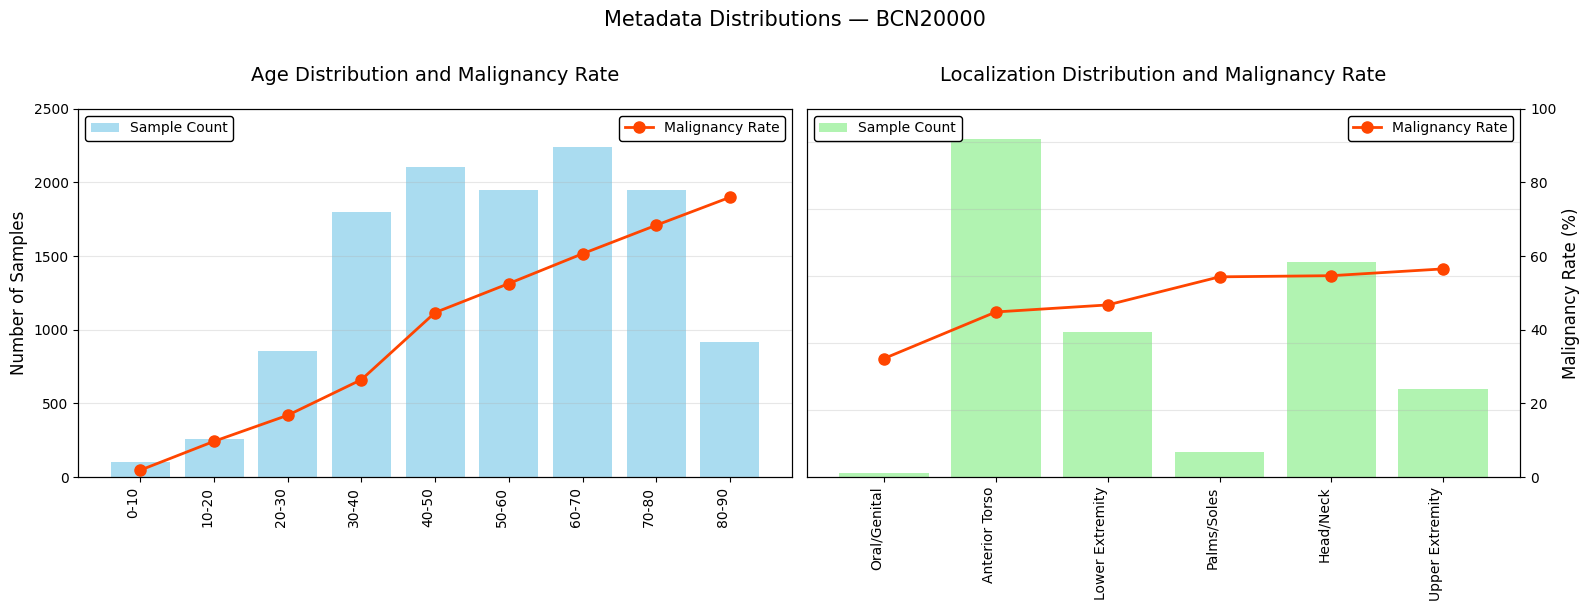

In [5]:
fig_meta = visualization.plot_metadata_distributions(meta, DANGEROUS_CLASSES, title_suffix=TITLE_SUFFIX)
plt.show()

In [6]:
fold_metrics, oof_lite, oof_heavy, oof_dynamic, route_mask_oof, route_components_oof = training.run_cv_pipeline(
    X_heavy, X_lite, X_tab, y, meta,
    class_names=CLASSES,
    safe_classes=SAFE_CLASSES,
    dangerous_classes=DANGEROUS_CLASSES,
    lite_energy_dir=LITE_DIR,
    heavy_energy_dir=HEAVY_DIR,
    n_splits=5,
    risk_scaler=risk_scaler,
)

print("\n--- Cross-Validation Results (5 Folds) ---")
print(f"Lite Accuracy:    {np.mean(fold_metrics['acc_lite']):.4f} ± {np.std(fold_metrics['acc_lite']):.4f}")
print(f"Heavy Accuracy:   {np.mean(fold_metrics['acc_heavy']):.4f} ± {np.std(fold_metrics['acc_heavy']):.4f}")
print(f"EcoFair Accuracy: {np.mean(fold_metrics['acc_dynamic']):.4f} ± {np.std(fold_metrics['acc_dynamic']):.4f}")
print(f"Routing Rate:     {np.mean(fold_metrics['routing_rate'])*100:.2f}% ± {np.std(fold_metrics['routing_rate'])*100:.2f}%")
print(f"Energy per Sample:{np.mean(fold_metrics['energy_cost']):.2f} J ± {np.std(fold_metrics['energy_cost']):.2f} J")


--- Fold 1/5 ---


I0000 00:00:1771776172.206593      24 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15511 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

I0000 00:00:1771776176.043262      79 service.cc:152] XLA service 0x7e5c080104f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1771776176.043301      79 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1771776176.568905      79 cuda_dnn.cc:529] Loaded cuDNN version 91002
I0000 00:00:1771776179.126130      79 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

  Lite: 0.5513 | Heavy: 0.5625 | EcoFair: 0.5601 | Route: 53.2% | Energy: 0.28 J/sample

--- Fold 2/5 ---


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

  Lite: 0.5434 | Heavy: 0.5417 | EcoFair: 0.5463 | Route: 54.8% | Energy: 0.28 J/sample

--- Fold 3/5 ---


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

  Lite: 0.5570 | Heavy: 0.5500 | EcoFair: 0.5579 | Route: 47.3% | Energy: 0.26 J/sample

--- Fold 4/5 ---


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

  Lite: 0.5919 | Heavy: 0.5446 | EcoFair: 0.5861 | Route: 50.9% | Energy: 0.27 J/sample

--- Fold 5/5 ---


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

  Lite: 0.5424 | Heavy: 0.5254 | EcoFair: 0.5307 | Route: 52.4% | Energy: 0.27 J/sample

--- Cross-Validation Results (5 Folds) ---
Lite Accuracy:    0.5572 ± 0.0182
Heavy Accuracy:   0.5448 ± 0.0121
EcoFair Accuracy: 0.5562 ± 0.0182
Routing Rate:     51.72% ± 2.56%
Energy per Sample:0.27 J ± 0.01 J


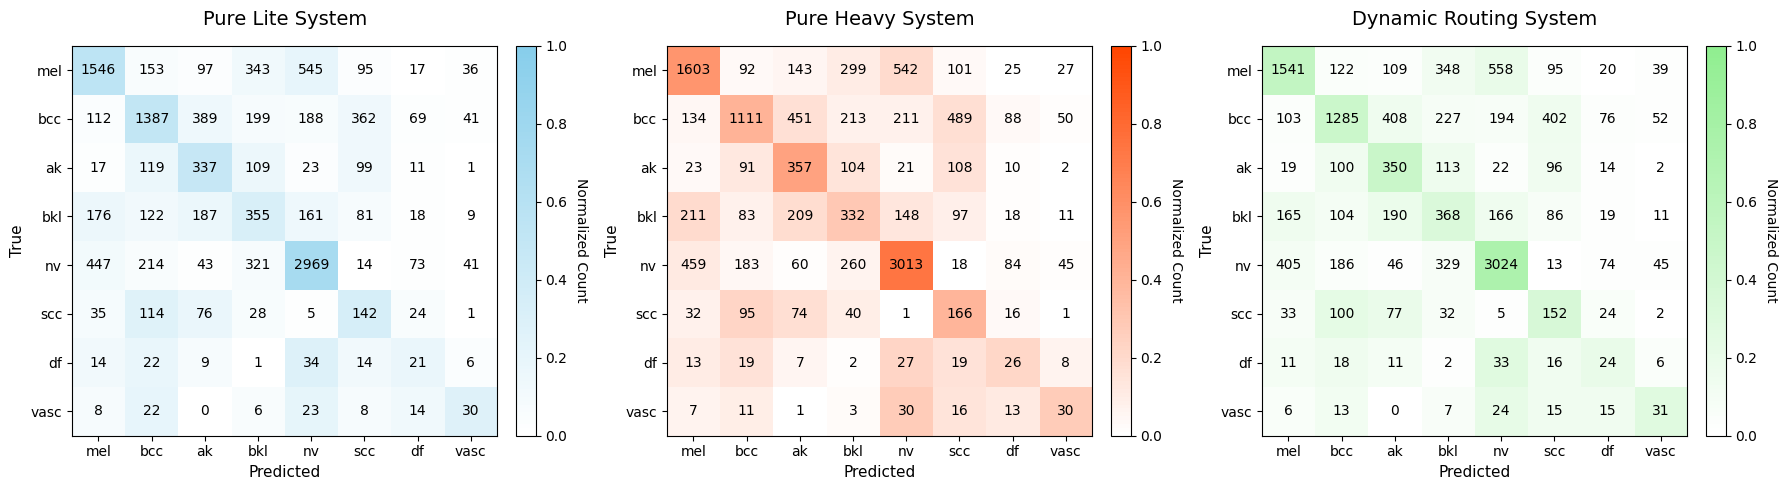

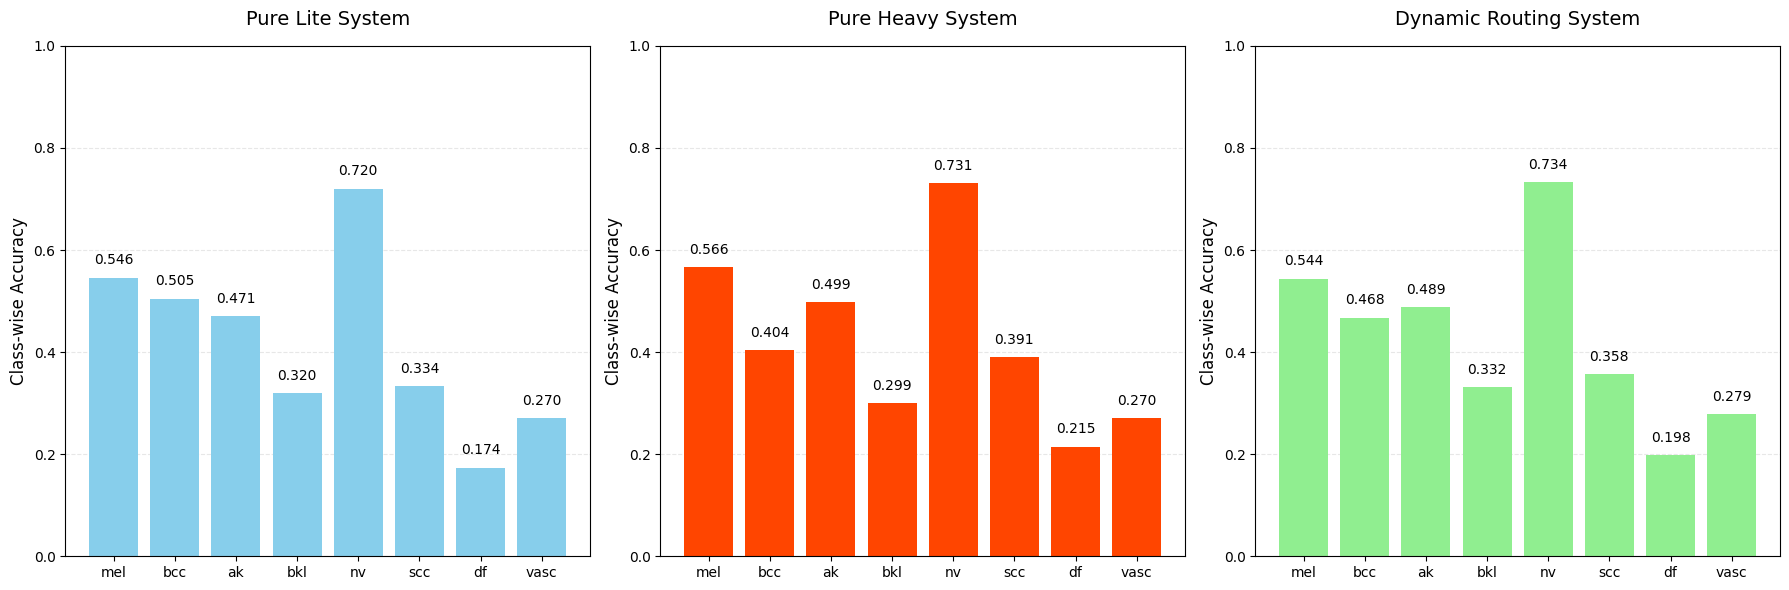

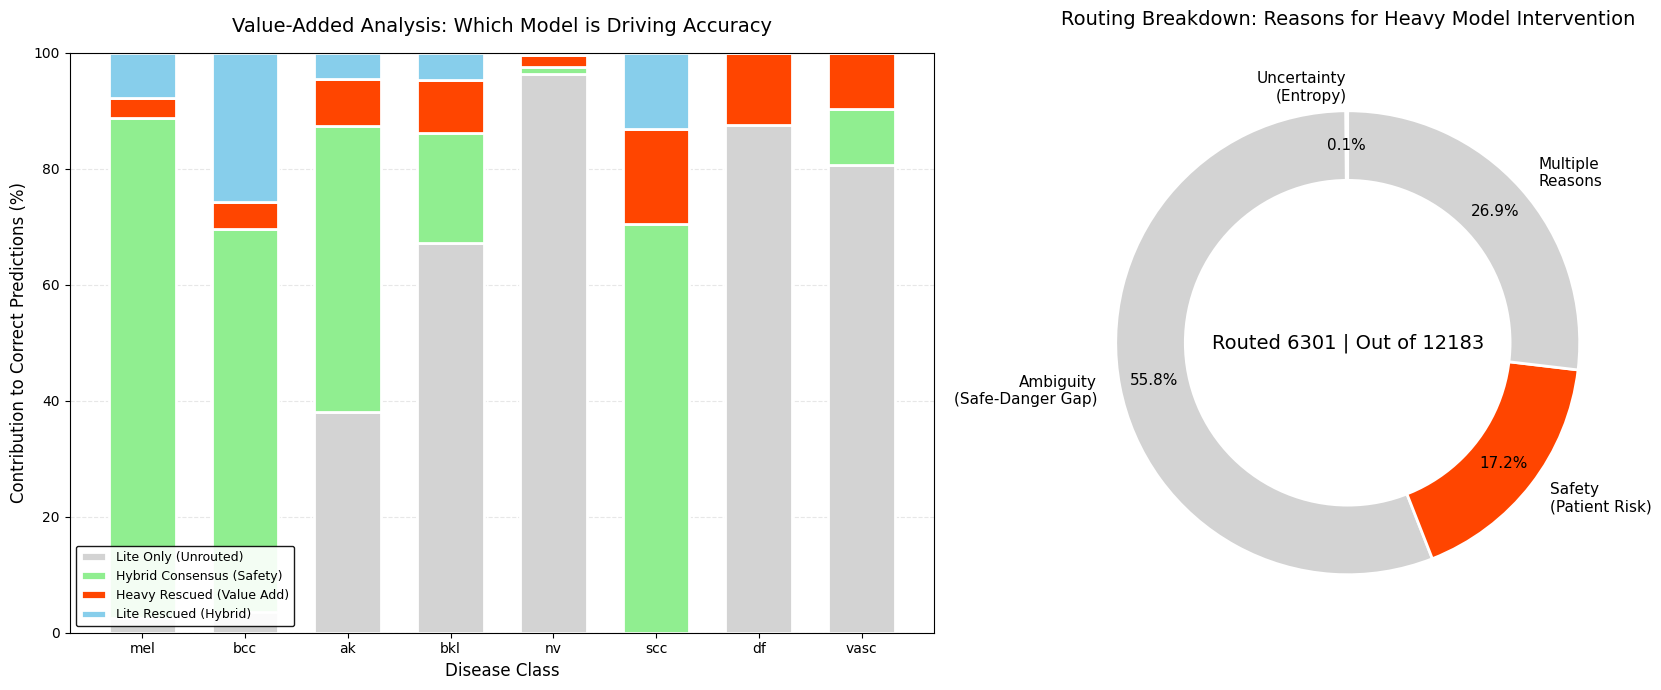

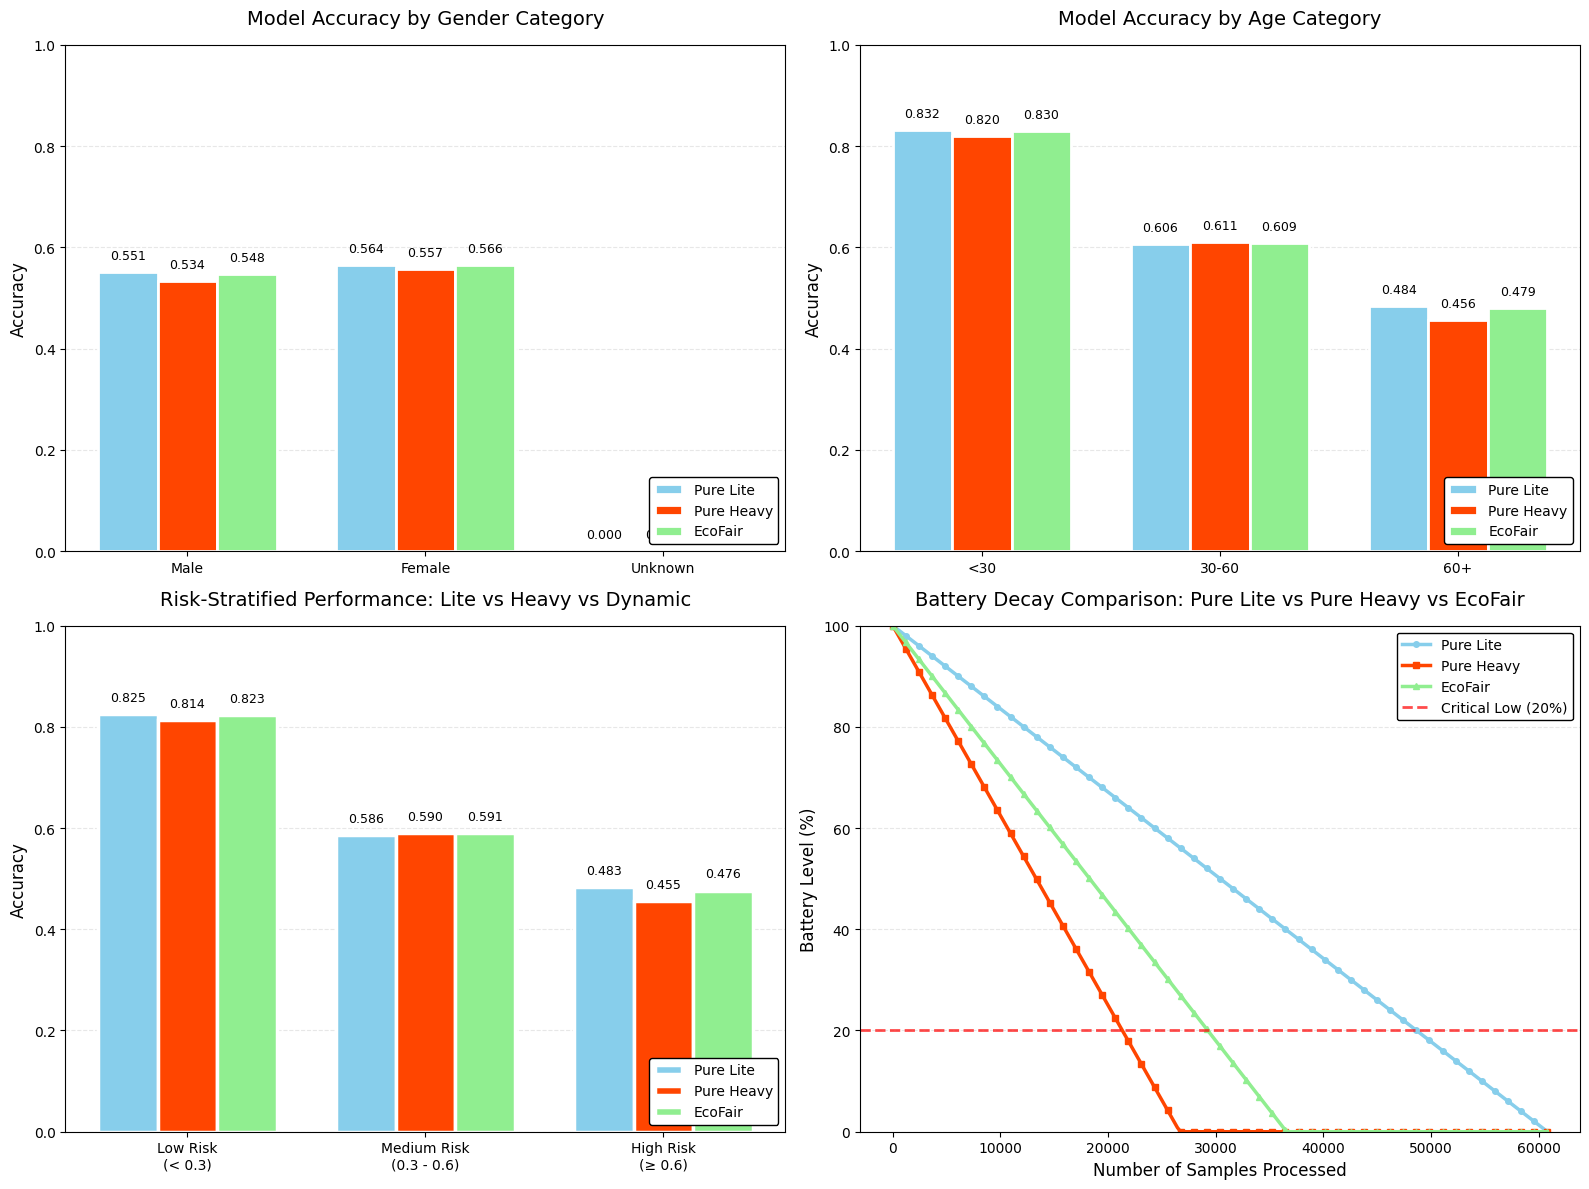

In [7]:
y_true_oof = np.argmax(y, axis=1)
entropy_oof = routing.calculate_entropy(oof_lite)
safe_indices   = [CLASSES.index(c) for c in SAFE_CLASSES]
danger_indices = [CLASSES.index(c) for c in DANGEROUS_CLASSES]
prob_safe_oof    = oof_lite[:, safe_indices].sum(axis=1)
prob_danger_oof  = oof_lite[:, danger_indices].sum(axis=1)
safe_danger_gap_oof = prob_safe_oof - prob_danger_oof

joules_lite  = utils.load_energy_stats(LITE_DIR)
joules_heavy = utils.load_energy_stats(HEAVY_DIR)
joules_lite  = joules_lite  if joules_lite  is not None else 1.0
joules_heavy = joules_heavy if joules_heavy is not None else 2.5
routing_rate_oof = route_mask_oof.sum() / len(route_mask_oof)

fig_cm = visualization.plot_confusion_matrix_comparison(
    y_true_oof, oof_lite, oof_heavy, oof_dynamic, CLASSES
)
plt.show()

fig_classwise = visualization.plot_classwise_accuracy_bars(
    y_true_oof, oof_lite, oof_heavy, oof_dynamic, CLASSES
)
plt.show()

fig_va_doughnut, axes_va_doughnut = plt.subplots(1, 2, figsize=(18, 7))
visualization.plot_value_added_bars(
    y_true_oof, oof_lite, oof_heavy, oof_dynamic, CLASSES,
    route_mask=route_mask_oof, ax=axes_va_doughnut[0]
)
visualization.plot_routing_breakdown_doughnut(
    entropy_oof, safe_danger_gap_oof, route_mask_oof, len(route_mask_oof),
    ax=axes_va_doughnut[1], route_components=route_components_oof
)
plt.tight_layout()
plt.show()

try:
    fig_comprehensive, axes_comprehensive = plt.subplots(2, 2, figsize=(16, 12))
    visualization.plot_gender_age_accuracy(
        y_true_oof, oof_lite, oof_heavy, oof_dynamic, meta, CLASSES,
        axes=(axes_comprehensive[0, 0], axes_comprehensive[0, 1])
    )
    visualization.plot_risk_stratified_accuracy(
        y_true_oof, oof_lite, oof_heavy, oof_dynamic, meta,
        risk_scaler=risk_scaler, ax=axes_comprehensive[1, 0]
    )
    visualization.plot_battery_decay(
        joules_lite, joules_heavy, routing_rate_oof, capacity_joules=10000,
        ax=axes_comprehensive[1, 1]
    )
    plt.tight_layout()
    plt.show()
except TypeError:
    try:
        plt.close(fig_comprehensive)
    except NameError:
        pass
    fig_gender_age = visualization.plot_gender_age_accuracy(
        y_true_oof, oof_lite, oof_heavy, oof_dynamic, meta, CLASSES
    )
    plt.show()
    fig_risk_battery, axes_risk_battery = plt.subplots(1, 2, figsize=(20, 6))
    visualization.plot_risk_stratified_accuracy(
        y_true_oof, oof_lite, oof_heavy, oof_dynamic, meta,
        risk_scaler=risk_scaler, ax=axes_risk_battery[0]
    )
    visualization.plot_battery_decay(
        joules_lite, joules_heavy, routing_rate_oof, capacity_joules=10000,
        ax=axes_risk_battery[1]
    )
    plt.tight_layout()
    plt.show()


--- Fairness Summary (Dangerous Classes, Subgroup Macro TPR) ---
         macro_tpr_mean  macro_tpr_worst_group  macro_tpr_gap
Model                                                        
Lite             0.4282                 0.3612         0.1464
EcoFair          0.4179                 0.3241         0.1782
Heavy            0.4077                 0.2921         0.2014

  Pure Lite

  Equal Opportunity (TPR) — Dangerous Classes:
Class                   bcc    mel    scc
Subgroup                                 
Age 30-60 (n=5856)   0.4629 0.4975 0.1233
Age 60+ (n=5108)     0.5327 0.6123 0.3778
Age <30 (n=1219)     0.4375 0.2967      -
Sex: Female (n=5763) 0.4664 0.5317 0.2615
Sex: Male (n=6420)   0.5307 0.5593 0.3661

  Demographic Parity Rate — Dangerous Classes:
Class                   bcc    mel    scc
Subgroup                                 
Age 30-60 (n=5856)   0.1294 0.1916 0.0176
Age 60+ (n=5108)     0.2619 0.2330 0.1394
Age <30 (n=1219)     0.0468 0.0353 0.0000
Sex: Female

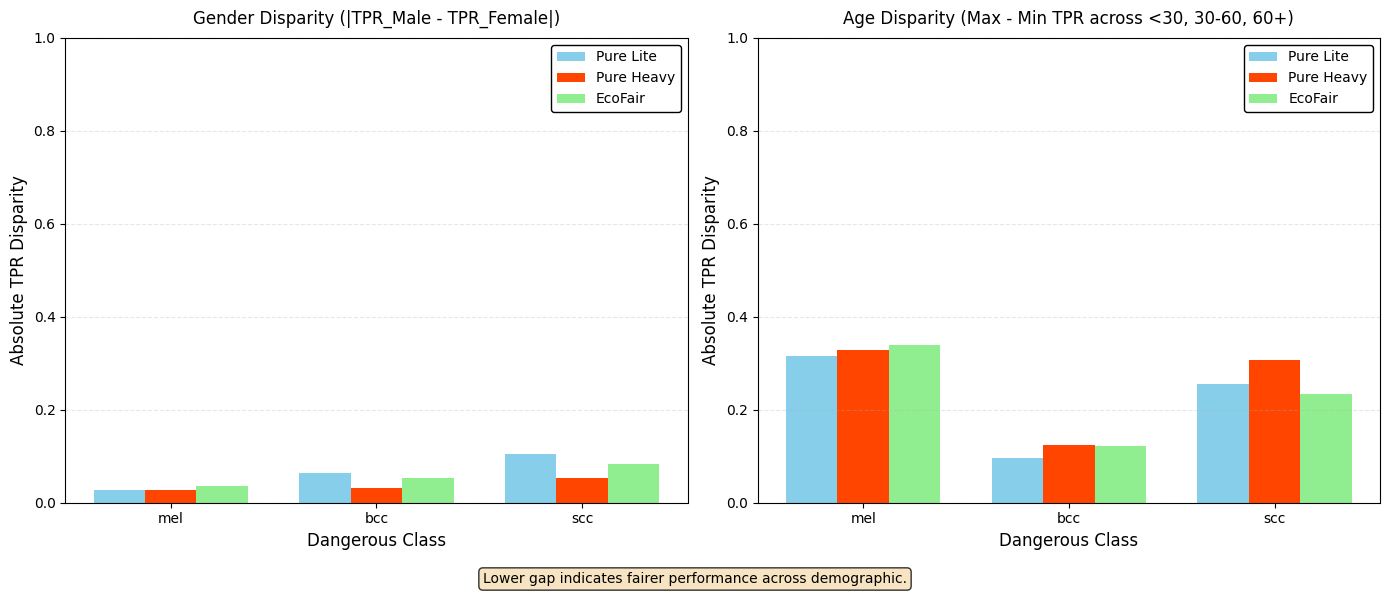

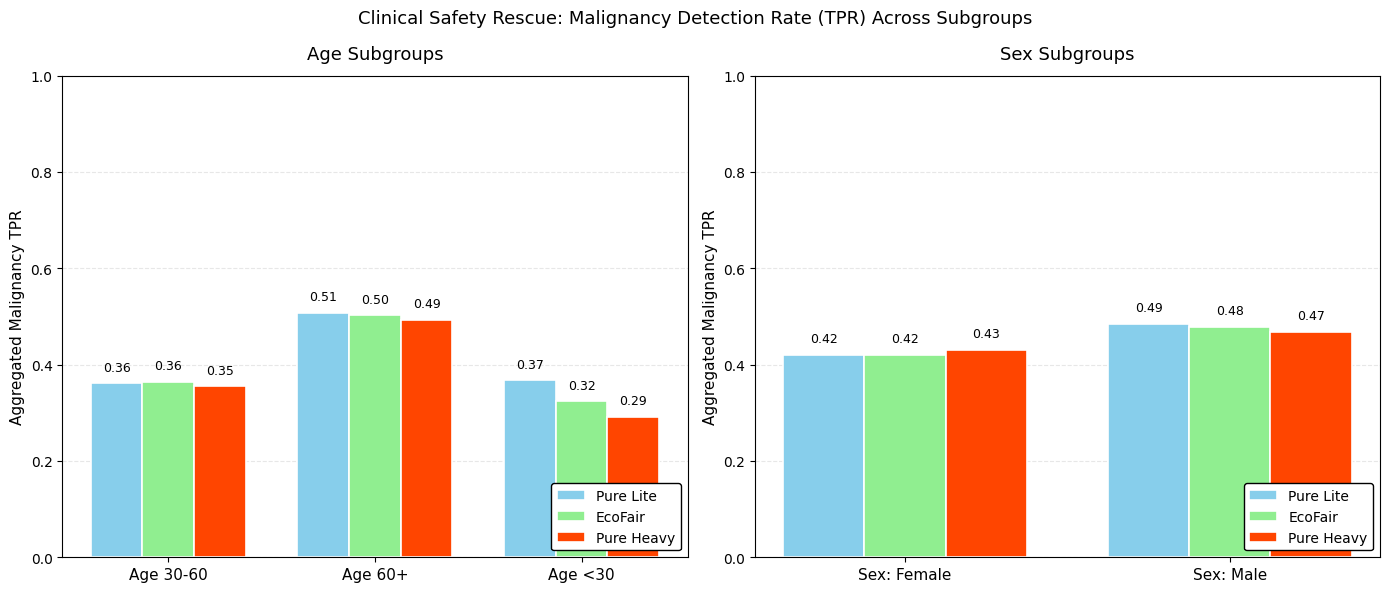

In [8]:
y_true_labels    = np.argmax(y, axis=1)
lite_pred_labels = np.argmax(oof_lite, axis=1)
heavy_pred_labels  = np.argmax(oof_heavy, axis=1)
dynamic_pred_labels = np.argmax(oof_dynamic, axis=1)

fairness_ecofair = fairness.generate_fairness_report(
    y_true_labels, dynamic_pred_labels, meta, CLASSES
)
fairness_lite = fairness.generate_fairness_report(
    y_true_labels, lite_pred_labels, meta, CLASSES
)
fairness_heavy = fairness.generate_fairness_report(
    y_true_labels, heavy_pred_labels, meta, CLASSES
)

def _fairness_summary(reports: dict, dangerous_classes) -> pd.DataFrame:
    """
    Compute a compact fairness summary table over dangerous classes only.

    For each model (rows), computes across all demographic subgroups:
      - macro_tpr_mean      : mean of per-subgroup macro-avg TPR
      - macro_tpr_worst_group: minimum per-subgroup macro-avg TPR
      - macro_tpr_gap       : max minus min per-subgroup macro-avg TPR

    Args:
        reports: dict of {label: fairness_df} from generate_fairness_report
        dangerous_classes: list of dangerous class names

    Returns:
        pd.DataFrame with one row per model
    """
    rows = []
    for label, df in reports.items():
        if df is None or df.empty:
            rows.append({'Model': label, 'macro_tpr_mean': float('nan'),
                         'macro_tpr_worst_group': float('nan'), 'macro_tpr_gap': float('nan')})
            continue
        subset = df[df['Class'].isin(dangerous_classes)].copy()
        subset['_tpr'] = pd.to_numeric(subset['Equal_Opportunity_TPR'], errors='coerce')
        sg_macro = subset.groupby('Subgroup')['_tpr'].mean()
        sg_macro = sg_macro.dropna()
        if sg_macro.empty:
            rows.append({'Model': label, 'macro_tpr_mean': float('nan'),
                         'macro_tpr_worst_group': float('nan'), 'macro_tpr_gap': float('nan')})
            continue
        rows.append({
            'Model':                label,
            'macro_tpr_mean':       round(float(sg_macro.mean()), 4),
            'macro_tpr_worst_group': round(float(sg_macro.min()),  4),
            'macro_tpr_gap':        round(float(sg_macro.max() - sg_macro.min()), 4),
        })
    summary = pd.DataFrame(rows).set_index('Model')
    return summary

_fairness_reports = {
    'Lite':    fairness_lite,
    'EcoFair': fairness_ecofair,
    'Heavy':   fairness_heavy,
}
pd.set_option('display.float_format', '{:.4f}'.format)
print("\n--- Fairness Summary (Dangerous Classes, Subgroup Macro TPR) ---")
print(_fairness_summary(_fairness_reports, DANGEROUS_CLASSES).to_string())

def _print_tpr_dp(label, fairness_df, dangerous_classes):
    """Print TPR and Demographic Parity tables filtered to dangerous classes only."""
    print(f"\n{'='*60}")
    print(f"  {label}")
    print(f"{'='*60}")
    if fairness_df.empty:
        print("  No data.")
        return
    df = fairness_df[fairness_df['Class'].isin(dangerous_classes)].copy()
    df['Subgroup'] = df.apply(lambda r: f"{r['Subgroup']} (n={int(r['Count'])})", axis=1)
    import pandas as pd
    pd.set_option('display.float_format', '{:.4f}'.format)
    print("\n  Equal Opportunity (TPR) — Dangerous Classes:")
    print(df.pivot(index='Subgroup', columns='Class', values='Equal_Opportunity_TPR').fillna('-').to_string())
    print("\n  Demographic Parity Rate — Dangerous Classes:")
    print(df.pivot(index='Subgroup', columns='Class', values='Demographic_Parity_Rate').fillna('-').to_string())

_print_tpr_dp('Pure Lite',  fairness_lite,    DANGEROUS_CLASSES)
_print_tpr_dp('Pure Heavy', fairness_heavy,   DANGEROUS_CLASSES)
_print_tpr_dp('EcoFair',    fairness_ecofair, DANGEROUS_CLASSES)

fairness.print_fairness_audit(fairness_ecofair)
visualization.plot_fairness_disparity(
    fairness_lite, fairness_heavy, fairness_ecofair, DANGEROUS_CLASSES
)
plt.show()
visualization.plot_clinical_safety_rescue(
    fairness_lite, fairness_heavy, fairness_ecofair, dangerous_classes=DANGEROUS_CLASSES
)
plt.show()